<a href="https://colab.research.google.com/github/scarletdskim/projects/blob/main/AI_02_%EA%B9%80%EB%8B%A4%EC%86%94_Section4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **리뷰로 알아보는 감성분석(sentiment analysis)** : 별점 5점은 진짜 만족도 5점일까?

---




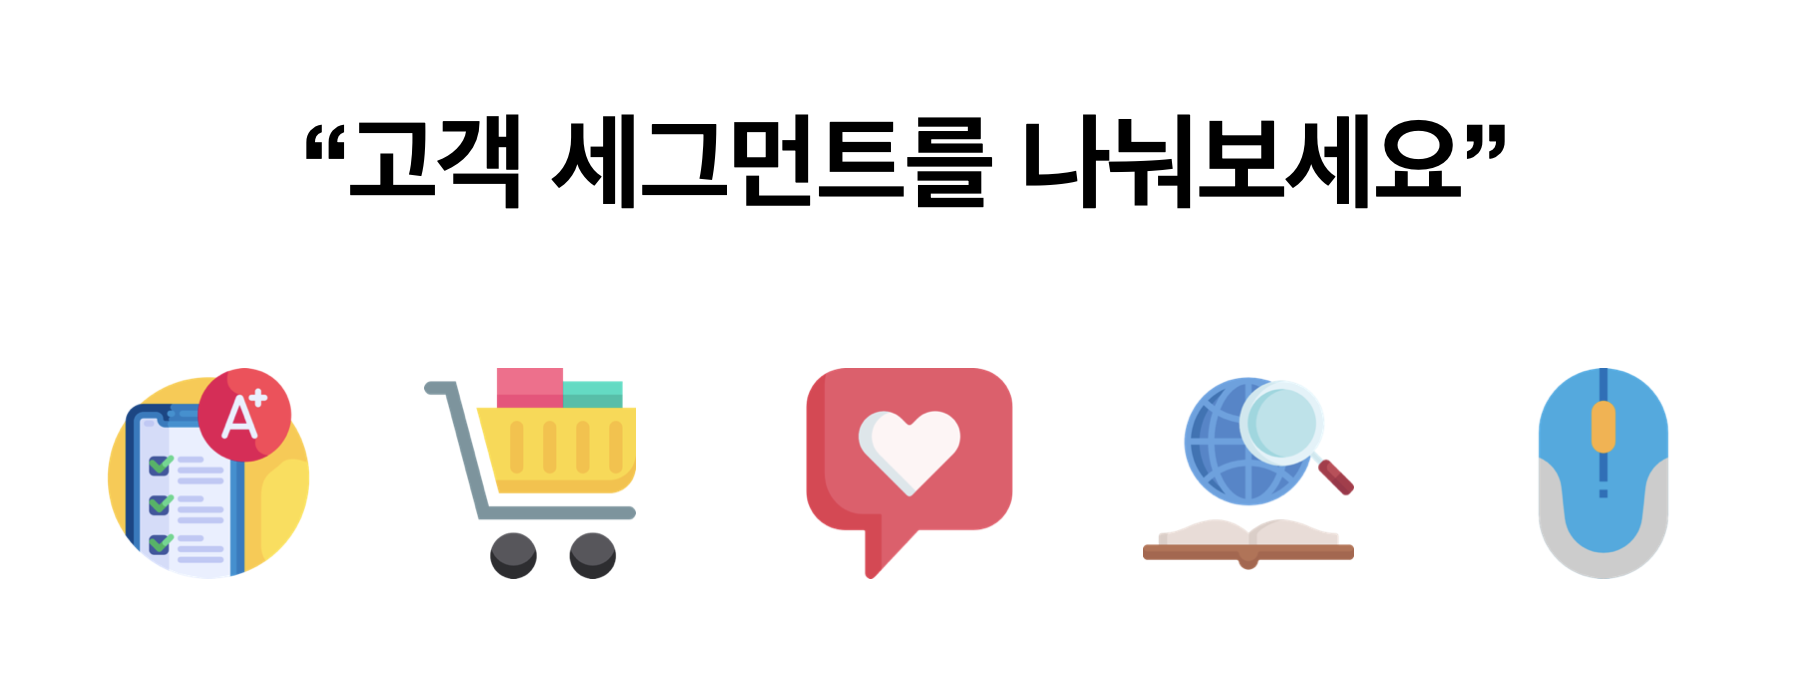

저와 함께 하는 동료에게 언젠가 던져보고 싶은 질문 두 개가 있습니다. 이 프로젝트는 이 질문에 스스로 대답하기 위해 시작했습니다. 

    [질문 1]

    당신이 커머스 회사의 데이터 분석가라고 가정하자. '정형화된 데이터 말고, 다른 데이터를 활용해서 고객의 세그먼트를 나눠보세요' 라는 퀘스트를 받았다. 
    어떤 기준으로 고객의 세그먼트를 나눌 것인가? 

    [질문 2]

    이 회사의 어플에는 유저의 취향에 맞는 상품/서비스를 추천해주는 기능이 구현되어있다. 당신이라면 추천 알고리즘에 어떤 데이터를 활용할 것인가?

 제 생각은 다음과 같습니다.

     1. 고객이 남긴 리뷰의 별점을 만족도라는 항목으로 고객 세그먼트에 반영할 수 있다. 하지만 별점과 리뷰의 감성이 반드시 일치하지 않을 것이라는 가설을 세우고, 
     별점 대신 텍스트에서 감성을 분류해내면 이를 활용해 고객이 특정 카테고리나 상품에 얼만큼 만족했는지를 수치화 할 수 있을 것이다.

     2. 1을 활용한다. 일부 상품 카테고리나 특정 상품에 쓴 리뷰의 감성을 불만족(0) ~ 만족(1) 의 척도로 가정했을 때, 
     1에 가까운 항목은 노출의 우선순위를 높이고 반대로 0에 가까운 항목은 제외하거나 노출 순위를 최대한 뒤로 할 수 있다.

아래에서는 배달 앱 사용자들이 음식점에 남긴 리뷰 텍스트와 별점 데이터를 바탕으로, 리뷰 텍스트에서 느껴지는 감성이 긍정(1), 부정(0)중 어디에 해당하는지 예측하기 위해 tensorflow로 기계 학습을 진행한 과정을 다룹니다. 학습한 결과를 평가해보고 이를 바탕으로 어떤 모델을 최종적으로 선택해야 하는지 과정이 서술되어 있으며, 편의를 위해 평어체를 사용합니다.

### Question : 시작 전 생각해 볼 몇 가지 주제


- 어떤 기준으로 고객 집단을 분류할 수 있을까?
- Explicit Data & Implicit Data
- 배달 음식을 먹고, 음식점에 별점을 5점 주었다. 진짜 만족도가 높다는 뜻일까?

### **PART 1 : EDA를 통해, 간단하게 데이터 특성을 이해해보자.**
---

(**⚠️주의** : Mecab 라이브러리 설치에 약 5분이 소요됩니다.)

#### 1-1. 라이브러리 설치 및 불러오기

In [ ]:
# 형태소 분석을 위해 Colab에 Mecab 설치
%%time
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

from konlpy.tag import Mecab

In [ ]:
## 한글 깨짐 방지를 위해 나눔폰트 설치
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

In [ ]:
# essential
import pandas as pd
import numpy as np

# get data from google drive
import os
from google.colab import drive

# for Preprocessing, Modeling, Evaluating
import re
from collections import Counter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import *
from __future__ import print_function
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔폰트로 설정
fm._rebuild()
plt.rc('font', family='NanumGothic')

for fontInfo in fm.fontManager.ttflist:
    if 'Nanum' in fontInfo.name:
        print(fontInfo.name+" = "+fontInfo.fname)

# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

%matplotlib inline
# 그래프 선명하게
%config InlineBackend.figure_format='retina'

# ignore warning
import warnings
warnings.filterwarnings(action='ignore')

#### 1-2. 데이터 가져오기

In [ ]:
drive.mount('/content/drive')

base_dir = '/content/drive/My Drive'
project_dir = os.path.join(base_dir, 'section4_project')

origin_df = pd.read_csv(project_dir + '/vendor_reviews_corpus.csv', index_col=[0]) # 인덱스컬럼 지정 ==> Unnamed : 0 을 없애줌

# 원본데이터 복구를 위해, origin_df를 카피하여 사용함
df = origin_df.copy()
df.columns = ['userId', 'reviewScore', 'reviewDetail']

Mounted at /content/drive


#### 1-3. 데이터 구조/분포 등 확인하기

- 약 3만 6천 명의 고객이 남긴 16만 개의 데이터로, 리뷰를 쓴 고객ID와 고객이 남긴 별점, 리뷰 내용이 들어있다.

- 리뷰내용엔 텍스트 말고도 특수문자나 이모지가 사용되어, 이것들을 전처리 해주는 작업이 필요해 보인다.

- 중복이 1만 행이 발견되나, 리뷰를 남긴 날짜/시간정보가 없어 진짜 중복이라고 판단하기 어렵다. 다른 날 다른 음식을 주문했더라도 동일한 유저가 동일한 내용(ex. 맛있어요)으로 같은 별점을 줄 수 있고, 리뷰가 적은 것 보단 많은 것이 유저의 성향을 판단하는데 더 도움이 될거라 생각하여 삭제하지 않는다.

- 리뷰점수는 0.5 ~ 5.0까지 총 10개의 class로 이루어져있다. 5점(57%)> 3점(13%) > 1점(12%) 이 두드러지며, 긍정적인 점수에 데이터가 더 몰려있기 때문에 이를 label로 쓰게 되면 편향된 분포임을 감안해야 한다. 

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162749 entries, 0 to 166158
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   userId        162749 non-null  object 
 1   reviewScore   162749 non-null  float64
 2   reviewDetail  162749 non-null  object 
dtypes: float64(1), object(2)
memory usage: 5.0+ MB


,userId,reviewScore,reviewDetail
0,13baccbd0e11b1c03db93f95f796c46f181fae8a,1.0,포장이 굉장히 깔끔하게 잘왔는데 양이 생각보다 적었어요. 남자분들은 맛만보는 정도일...
1,8d05b8f335b233aecbb276fa90bbe9524cb566a0,3.5,따뜻한상태로 바로 배달해주셔서 방금 나온 음식처럼 잘먹었어용~
3,cad9dfaf62220b0b220398ad85bd63f68e2b35d8,3.0,무난했어요 ㅎㅎㅎㅎ배달한것치곤 평타이상^^
4,c77032d2cf7dd9d7908fd30b130da809ae1727a4,5.0,깔끔하니 맛!\n제점수는\n★★★★☆
5,dd7ecda643a3e7f968a9031fc4ae67bad791d4ad,5.0,집 근처에 맛난 중국집을 발견하여 좋습니다\n특히 탕수육이 맛나네요~~^^


In [ ]:
df.nunique()

userId           36724
reviewScore         10
reviewDetail    130450
dtype: int64

In [ ]:
print(df.duplicated().value_counts())
df[df.duplicated()==True]

False    152155
True      10594
dtype: int64


,userId,reviewScore,reviewDetail
176,1cb2d07cbdce788f41e4b3c4b49038c2ab14bda2,5.0,좋아요
370,5798d4efd369b5dc0f3dc99bd9a463307767d726,5.0,맛있어요
707,22d88e84fa2c86b3e1d31fe5ef4bd3018eb5aad3,5.0,굿
1115,22d88e84fa2c86b3e1d31fe5ef4bd3018eb5aad3,5.0,굿
1254,5798d4efd369b5dc0f3dc99bd9a463307767d726,5.0,맛있어요
...,...,...,...
165469,addb5a9f5ebbbb20d6af3951e880ca1fd2e58c53,5.0,맛있게 잘 먹었습니다!
165810,9c3518418c8763e0c176a6a590a77da0b4b85fb6,5.0,양도 많고 맛있네요~~
165831,4f24e50312c3915bfe0f86ae2b1e06860348583a,5.0,맛있게 잘 먹었습니다~
166046,2a04fcf779aec8d4eb9afc799a6d96987dd7811f,5.0,맛있는 음식 감사드립니다 :)


In [ ]:
df.describe()

,reviewScore
count,162749.000000
mean,3.964553
std,1.429080
min,0.500000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
dist = df.groupby('reviewScore').count()[['userId']]
dist['percentage'] = dist['userId'] / dist['userId'].sum()
dist.style.bar(subset=['percentage'], color='#a49bed')

,userId,percentage
reviewScore,,
0.5,468,0.002876
1.0,19421,0.119331
1.5,1761,0.010820
2.0,4340,0.026667
2.5,3346,0.020559
3.0,20653,0.126901
3.5,5342,0.032824
4.0,9095,0.055884
4.5,5531,0.033985


#### 1-4. 데이터에 레이블 입혀주고, 분포 확인하기
<img src="https://i.pinimg.com/originals/e0/6d/9f/e06d9fd97dec947ae1abbc037d066c91.png" width='500'>


만족 여부가 아니라, 만족 정도를 리커드척도로 측정했기 때문에 중간값인 3점은 감정을 판단하기 어렵다. 

→ 따라서 0.5 ~ 2.5 까지를 0(부정😡), 3.5 ~ 5.0 까지를 1(긍정😁) 으로 데이터를 라벨링 해준다.

In [ ]:
label_lst = []

for idx, val in enumerate(df['reviewScore']):
    if val <= 2.5:
      label_lst.append(0)
    elif val >= 3.5:
      label_lst.append(1)
    elif val == 3.0:
      label_lst.append(np.nan)
    else:
      print(f'please check index : {idx} , reviewScore value : {val}')

df['label'] = label_lst

# 라벨이 할당되지 않은 3점짜리 row를 제외
df = df[~df['label'].isnull()]

긍정(1) : 부정(0) = 8 : 2 정도로, 긍정적인 리뷰에 편향되어 있다. 편향된 레이블 집합은 학습에 영향을 줄 수 있기 때문에

- 훈련/검증 데이터셋을 나눌 때 balance를 맞출 수 있도록 stratify를 사용해주고

- 부정(0)에 가중치를 더 주거나, 밸런스를 최대한 맞춰주는 방향으로 학습을 유도한다.

- 그럼에도, 너무 성능이 나오지 않으면 최대한 5:5의 비중이 나오도록 샘플링을 다시 해서 학습할 수 있음.

1.0    0.793548
0.0    0.206452
Name: label, dtype: float64

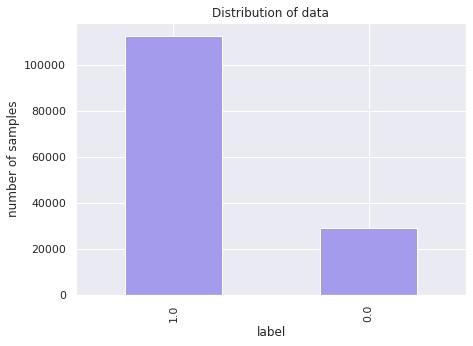

In [ ]:
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(1,figsize=(7,5))
ax.set_title('Distribution of data')
ax.set_xlabel('label')
ax.set_ylabel('number of samples')
df['label'].value_counts().plot(kind='bar', color='#a49bed');
df['label'].value_counts(normalize=True)

### **PART 2 : 전처리를 통해, 컴퓨터가 잘 학습할 수 있도록 해주자.**

---

한국어를 컴퓨터가 학습할 수 있도록 처리해주기 위해서는, 아래와 같은 작업이 필요하다.

1. 특수문자/이모지를 제거하고, 영어가 있다면 대문자 or 소문자 하나로 통일해주는 등의 **정제(Cleansing)** 작업
2. 컴퓨터가 잘 학습할 수 있도록 단어/문자등으로 쪼개주는 **토큰화(Tokenization)** 
3. 등장하는 단어긴 하지만, 분석에는 사용하지 않을 단어를 지정해 제거해주는  **불용어(Stop words)** 제거
3. 이음동의어(Synonym) 를 통합시켜 같은 단어로 만들어주는 **정규화(Normalization)** 
4. 컴퓨터가 이해할 수 있도록 문자를 숫자로 **인코딩(Encoding)** 
5. 컴퓨터가 학습할 수 있도록 문자 길이를 맞춰주는 **패딩(Padding)**


#### 2-1. 데이터 정제하기


In [ ]:
def cleaning(text):
    """text 문자열을 정돈해줍니다.
    Args:
        text (str): 클리닝할 문자열
    Returns:
        list: 클리닝을 거친 문장이 저장된 리스트
    """

    # 숫자, 영어(소/대문자), 한글을 제외한 나머지(^) 지우기
    regex = r'[^0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣 ]'

    # 정규식 적용
    sentence = re.sub(regex, '', text)

    # 제거하고 나면, 공백이 여러개인 문자가 생기기도 함(ex: 맛있네 ... 그런데 -> 맛있네,  , 그런데)
    pattern = re.compile(r'\s\s+')
    sentence = re.sub(pattern, '', sentence)

    # 대문자를 소문자로 치환
    sentence = sentence.lower()
    
    return sentence

In [ ]:
# 클리닝 적용
df['reviewDetail'] = df['reviewDetail'].apply(cleaning)

# 클리닝 후 리뷰에 아무것도 남아있지 않다면(='') 제거하기
df['reviewDetail'].replace('', np.nan, inplace=True)
df = df[~df['reviewDetail'].isnull()]
df.isnull().sum()

userId          0
reviewScore     0
reviewDetail    0
label           0
dtype: int64

In [ ]:
print('전처리 후 최종 남은 데이터 : ', len(df))
df.head()

전처리 후 최종 남은 데이터 :  141481


,userId,reviewScore,reviewDetail,label
0,13baccbd0e11b1c03db93f95f796c46f181fae8a,1.0,포장이 굉장히 깔끔하게 잘왔는데 양이 생각보다 적었어요 남자분들은 맛만보는 정도일것...,0.0
1,8d05b8f335b233aecbb276fa90bbe9524cb566a0,3.5,따뜻한상태로 바로 배달해주셔서 방금 나온 음식처럼 잘먹었어용,1.0
4,c77032d2cf7dd9d7908fd30b130da809ae1727a4,5.0,깔끔하니 맛제점수는,1.0
5,dd7ecda643a3e7f968a9031fc4ae67bad791d4ad,5.0,집 근처에 맛난 중국집을 발견하여 좋습니다특히 탕수육이 맛나네요,1.0
6,0b7c03aeeaa5157ab40c0bffee716f1298c88b4b,4.5,매운맛 맛있어요,1.0


#### 2-2. 토큰화(Tokenization) & 불용어(stopwords) 처리



<img src="https://blog.kakaocdn.net/dn/bM2yU7/btq20ENXwn9/WpbFErDiHRkjvgsCIEpr50/img.png" width="600">

한국어를 작게 작게 쪼개주기 위해서는, 우리가 배운 spacy나 NLTK를 사용하기에 어려움이 있다.

**"지금 맥북이 너무 예전에 쓰던거라 맥북의 성능이 별로야. 다른 사람들은 어떤 맥북을 쓰는 지 궁금하다."**

위문장에서 맥북은 3번 등장했지만 이,의,을이란 조사가 붙어서 '맥북이', '맥북의', '맥북을' 이라는 서로 다른 단어로 인식하게 되기 때문이다. 

어절단위로 토크나이징해주는 spacy나 NLTK는 띄어쓰기로 구분해도 무리없는 영어에 적합하다.

따라서 한국어로 쓰인 리뷰데이터는, 형태소 분석기 중 [MeCab](https://www.google.com/search?rlz=1C5CHFA_enKR954KR956&sxsrf=ALeKk00kjs9_e2CXUr0C5frlcFMjQteDqQ:1624894893632&q=mecab+%EC%9D%B4%EB%9E%80&spell=1&sa=X&ved=2ahUKEwiOoLqX1brxAhWkyosBHfDeCN8QBSgAegQIARAw&biw=1440&bih=707)을 사용해서 토큰화를 해준다. 

(비교를 위해 spacy를 사용해 단어단위로도 토큰화를 해주었다.)




<참고 자료>

[[자연어처리] 한국어 토큰화 구현(KoNLPy) : 한국어 텍스트 전처리는 어떻게 할까?](https://han-py.tistory.com/283)

[[NLP]자연어처리 - 한국어 전처리를 위한 기법들](https://ebbnflow.tistory.com/246)

2-2-1. 형태소 단위의 불용어 리스트(stop_morphs_lst)와 단어 단위의 불용어 리스트(stop_words_lst) 만들기


In [ ]:
# 텍스트 파일 읽어오기
with open(project_dir + "/korean_stopwords_ranks_nl.txt") as f1, open(project_dir + "/korean_stopwords_spikeekips.txt") as f2:
    stop_words_1 = [line.strip() for line in f1]
    stop_words_2 = [line.strip() for line in f2]
    
# 불용어 리스트 합치기
stop_words_lst = stop_words_1 + stop_words_2
print('불용어 중복 포함 개수 : ', len(stop_words_lst))

# 중복 제거 (1,271개 -> 약 500개로 축소)
stop_words_lst = list(dict.fromkeys(stop_words_lst))
print('불용어 중복 제거 후 : ', len(stop_words_lst))

불용어 중복 포함 개수 :  1271
불용어 중복 제거 후 :  598


In [ ]:
stop_morphs_df = pd.read_csv(project_dir + '/korean_stopwords_bab2min.txt', sep = '\t', header = None, names = ['형태','품사','비율'])
stop_morphs_lst = stop_morphs_df['형태'].tolist()

# 불용어 추가해주기
custom_stop_morphs = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '어', '요', '아요', '네요', '어요']
stop_morphs_lst = stop_morphs_lst + custom_stop_morphs
print('불용어 중복 제거 전 : ',len(stop_morphs_lst))

# 중복 제거
stop_morphs_lst = list(dict.fromkeys(stop_morphs_lst))
print('불용어 중복 제거 후 : ', len(stop_morphs_lst))


불용어 중복 제거 전 :  128
불용어 중복 제거 후 :  115


2-2-A. Mecab으로 형태소를 쪼개고, 불용어 처리하기



In [ ]:
mecab = Mecab()
df['reviewDetail_mecab'] = df['reviewDetail'].apply(mecab.morphs)
df['reviewDetail_mecab'] = df['reviewDetail_mecab'].apply(lambda x : [morph for morph in x if morph not in stop_morphs_lst])

2-2-B. spacy로 단어 단위로 자르고, 불용어 처리하기

In [ ]:
# Load general-purpose pretrained models to predict named entities, part-of-speech tags and syntactic dependencies
## https://spacy.io/models
## python -m spacy download en_core_web_sm
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")

# Tokenizer 생성
tokenizer = Tokenizer(nlp.vocab)

# Tokenizer Pipe
tokens = []
# 토큰화 (in stream process)
# .pipe streams input, and produces streaming output
for doc in tokenizer.pipe(df['reviewDetail']):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

df['reviewDetail_spacy'] = tokens
df['reviewDetail_spacy'] = df['reviewDetail_spacy'].apply(lambda x : [word for word in x if word not in stop_words_lst])
df['reviewDetail_spacy'].head()

0    [포장이, 굉장히, 깔끔하게, 잘왔는데, 양이, 생각보다, 적었어요, 남자분들은, ...
1                [따뜻한상태로, 배달해주셔서, 방금, 나온, 음식처럼, 잘먹었어용]
4                                        [깔끔하니, 맛제점수는]
5         [집, 근처에, 맛난, 중국집을, 발견하여, 좋습니다특히, 탕수육이, 맛나네요]
6                                          [매운맛, 맛있어요]
Name: reviewDetail_spacy, dtype: object

In [ ]:
# 같은 텍스트로도, 어떻게 자르냐에 따라서 다른 모양을 보인다! 
df[df.columns.difference(['userId', 'reviewScore'])].head()

,label,reviewDetail,reviewDetail_mecab,reviewDetail_spacy
0,0.0,포장이 굉장히 깔끔하게 잘왔는데 양이 생각보다 적었어요 남자분들은 맛만보는 정도일것...,"[포장, 굉장히, 깔끔, 왔, 는데, 양, 보다, 었, 남자, 분, 맛, 만, 습니다]","[포장이, 굉장히, 깔끔하게, 잘왔는데, 양이, 생각보다, 적었어요, 남자분들은, ..."
1,1.0,따뜻한상태로 바로 배달해주셔서 방금 나온 음식처럼 잘먹었어용,"[따뜻, 상태, 로, 바로, 배달, 해, 셔서, 방금, 나온, 음식, 처럼, 먹, ...","[따뜻한상태로, 배달해주셔서, 방금, 나온, 음식처럼, 잘먹었어용]"
4,1.0,깔끔하니 맛제점수는,"[깔끔, 니, 맛, 제, 점수]","[깔끔하니, 맛제점수는]"
5,1.0,집 근처에 맛난 중국집을 발견하여 좋습니다특히 탕수육이 맛나네요,"[근처, 맛난, 중국집, 발견, 여, 습니다, 특히, 탕수육, 맛나]","[집, 근처에, 맛난, 중국집을, 발견하여, 좋습니다특히, 탕수육이, 맛나네요]"
6,1.0,매운맛 맛있어요,"[매운맛, 맛있]","[매운맛, 맛있어요]"


#### 2-3. 단어와 길이 분포 확인하고, 더 할 수 있는 작업이 없나 살펴보기

아래 3가지를 확인해보고, 필요한 전처리가 더 있다면 해주자.

- 어떤 단어(형태소)들이 주로 등장하는지
- 상위 n 개의 단어들이 전체에서 얼마나 큰 파이를 차지할지
- 긍정적인 리뷰와 부정적인 리뷰에서 자주 등장하는 단어(형태소)는 무엇이고, 어떻게 다른지


In [ ]:
def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [ ]:
wc_mecab = word_count(df['reviewDetail_mecab'])
wc_spacy = word_count(df['reviewDetail_spacy'])

In [ ]:
# 형태소로 자르니까 2만8천이었는데, 단어단위로 자르니까 20만... 엄청난 차이다.
# 일단 단어단위는 놔두고, 형태소로 자른 리뷰만 건드려보기로 한다.
wc_mecab.shape, wc_spacy.shape

((27891, 7), (204713, 7))

In [ ]:
# '맛있고 맛있으며 맛있다!' 라는 문장 1개와 
# '맛있는데 음..' 이라는 문장 1개로 이루어진 총 2개의 집합이 있다고 할 때,
# '맛있' 의 count=4, word_in_docs=2, word_in_docs_percent라고 하면 2/2 = 1이 된다.

(wc_mecab[:10].style
              .bar(subset=['word_in_docs', 'count'], color='#a49bed')
              .format({'rank': '{:.0f}',
                       'percent' : "{:.2%}", 
                       'cul_percent' : "{:.2%}", 
                       'word_in_docs_percent' : "{:.2%}"
              })
)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
37,맛있,57637,63929,1,5.07%,5.07%,40.74%
17,먹,36003,45194,2,3.58%,8.65%,25.45%
5,었,28070,32676,3,2.59%,11.24%,19.84%
11,맛,25023,27886,4,2.21%,13.45%,17.69%
3,는데,17473,19816,5,1.57%,15.02%,12.35%
90,너무,15479,17134,6,1.36%,16.37%,10.94%
8,습니다,14689,16436,7,1.30%,17.68%,10.38%
25,배달,9391,10168,8,0.81%,18.48%,6.64%
201,했,8296,9277,9,0.74%,19.22%,5.86%
0,양,8610,9141,10,0.72%,19.94%,6.09%


상위 10개의 단어들이 차지하는 비중 : 0.2
상위 100개의 단어들이 차지하는 비중 : 0.48
상위 1000개의 단어들이 차지하는 비중 : 0.83
상위 2000개의 단어들이 차지하는 비중 : 0.9
상위 3000개의 단어들이 차지하는 비중 : 0.93
상위 5000개의 단어들이 차지하는 비중 : 0.96


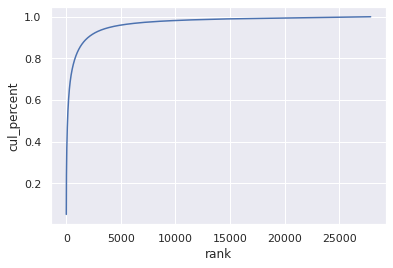

In [ ]:
sns.lineplot(x='rank', y='cul_percent', data=wc_mecab);

for n in [10, 100, 1000, 2000, 3000, 5000]:
    pie = round(wc_mecab[wc_mecab['rank'] <= n]['cul_percent'].max(), 2)
    print(f'상위 {n}개의 단어들이 차지하는 비중 : {pie}')

In [ ]:
def convert_ranking(df=df, col_name='reviewDetail_mecab'):

  # 각각의 리스트로 된 형태소를 쭉 풀어 하나의 어레이로 만든다.
  negative_words = np.hstack(df[df.label==0]['reviewDetail_mecab'].values)
  positive_words = np.hstack(df[df.label==1]['reviewDetail_mecab'].values)

  # 단어별로 등장횟수를 집계한다.
  negative_word_count = Counter(negative_words)
  positive_word_count = Counter(positive_words)

  # 집계한 내용을 바탕으로 데이터프레임으로 만들어줌
  negative_words_df = (pd.DataFrame
                        .from_dict(negative_word_count, orient='index')
                        .sort_values(0, ascending=False)
                        .reset_index()
                        .rename(columns={'index':'neg_words', 0:'neg_words_cnt'})
                        )

  positive_words_df = (pd.DataFrame
                        .from_dict(positive_word_count, orient='index')
                        .sort_values(0, ascending=False)
                        .reset_index()
                        .rename(columns={'index':'pos_words', 0:'pos_words_cnt'})
                        )
  
  return positive_words_df, negative_words_df

In [ ]:
positive_words_df = convert_ranking()[0]
negative_words_df = convert_ranking()[1]

부정리뷰, 긍정리뷰에서 각각 등장 횟수가 많은 20개 단어를 뽑아 비교했으나, 전체적인 톤에 큰 차이가 없어보였다.

In [ ]:
def top_n_words_df(start, end):

  top_n_words_df = pd.concat([positive_words_df[start:end], negative_words_df[start:end]], axis=1)

  return (top_n_words_df
          .style
          .bar(subset=['pos_words_cnt'], color='#97eaf1') 
          .bar(subset=['neg_words_cnt'], color='#ec9f94') 
          )

##### 2-3-1. 긍정 Vs 부정 상황별 고빈도어 Top 20

In [ ]:
# 등장횟수가 많은 상위 20개 단어들만 모아서, 데이터프레임으로 만든다.
top_n_words_df(0, 20)

,pos_words,pos_words_cnt,neg_words,neg_words_cnt
0,맛있,57404,먹,9053
1,먹,36141,맛,6633
2,었,27709,맛있,6525
3,맛,21253,는데,5427
4,는데,14389,었,4967
5,습니다,14083,너무,4825
6,너무,12309,음,2832
7,배달,8178,만,2815
8,굿,8105,했,2367
9,양,7276,습니다,2353


그래서 상위 20개를 제외하고, 20~40위의 단어들을 봤더니, 아까보다는 확연히 톤에서 차이가 난다.

In [ ]:
top_n_words_df(20, 40)

,pos_words,pos_words_cnt,neg_words,neg_words_cnt
20,넘,5045,고기,1511
21,거,4887,별로,1502
22,진짜,4814,포장,1409
23,만,4724,시켜,1391
24,지만,4472,주문,1378
25,합니다,4354,에서,1335
26,서,4343,왔,1303
27,깔끔,4107,시켰,1302
28,최고,4078,음식,1276
29,로,4046,아,1274


그래서 상위 20 개 단어 중 겹치는 단어를 불용어로 추가하고, 다시 상위 20개 단위를 살펴봤다.

In [ ]:
pos_words = pd.concat([positive_words_df[0:20], negative_words_df[0:20]], axis=1)['pos_words'].tolist()
neg_words = pd.concat([positive_words_df[0:20], negative_words_df[0:20]], axis=1)['neg_words'].tolist()

import collections

# 중복 단어만 따로 빼서 리스트로 만들어 줌
freq_morphs_lst = [item for item, count in collections.Counter(pos_words + neg_words).items() if count > 1]
print(freq_morphs_lst)

# 기존 사전과 중복되지 않도록 한 번 더 체크
stop_morphs_lst = stop_morphs_lst + freq_morphs_lst
stop_morphs_lst = list(dict.fromkeys(stop_morphs_lst))

['맛있', '먹', '었', '맛', '는데', '습니다', '너무', '배달', '양', '했', '았', '음', '어서', '시']


In [ ]:
df['reviewDetail_mecab'] = df['reviewDetail_mecab'].apply(lambda x : [morph for morph in x if morph not in stop_morphs_lst])

positive_words_df = convert_ranking()[0]
negative_words_df = convert_ranking()[1]

top_n_words_df(0, 20)


,pos_words,pos_words_cnt,neg_words,neg_words_cnt
0,굿,8105,만,2815
1,맛나,7191,거,2202
2,시켜,5885,서,1918
3,주문,5619,면,1628
4,잇,5466,그냥,1627
5,포장,5343,진짜,1569
6,넘,5045,고기,1511
7,거,4887,별로,1502
8,진짜,4814,포장,1409
9,만,4724,시켜,1391


##### 2-3-2. 긍정, 부정 리뷰별 길이 분포

부정적인 리뷰의 길이가 전체적으로 조금 더 길다.

샘플의 갯수는 확연히 차이가 나지만, 이 부분은 최초 샘플의 분포가 긍정(8):부정(2)임을 감안하여 절대적인 갯수 비교보다는 그래프의 분포와 평균을 참고했다.

긍정 리뷰의 평균 길이 : 6.38
부정 리뷰의 평균 길이 : 8.94


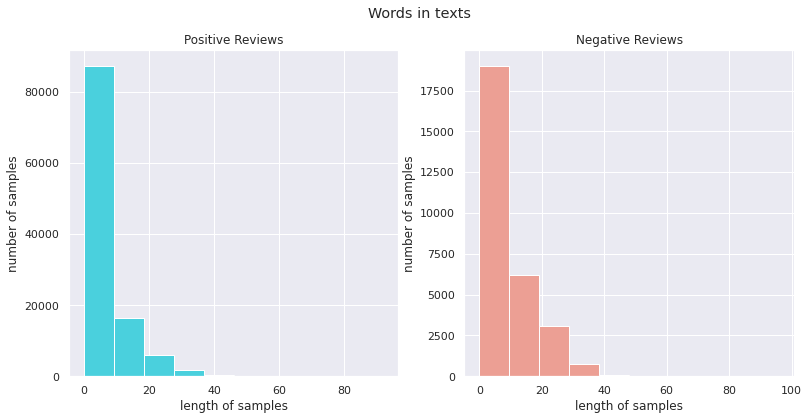

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
text_len = df[df['label']==1]['reviewDetail_mecab'].map(lambda x: len(x))
ax1.hist(text_len, color='#4ad0dd')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', round(np.mean(text_len), 2))

text_len = df[df['label']==0]['reviewDetail_mecab'].map(lambda x: len(x))
ax2.hist(text_len, color='#ec9f94')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', round(np.mean(text_len), 2))
plt.show()

####2-4. 인코딩 하기

위에서 쪼갠 단어들을 그대로 학습에 사용하면 컴퓨터는 이해하지 못한다.
 
따라서 문자를 숫자로 인코딩하는 과정이 필요한데, 여러 인코딩 방법 중 출현 빈도가 높은 단어에 낮은 정수를 부여하는 식으로 정수 인코딩을 진행한다.

Counter를 쓰거나, enumerate를 활용해도 되지만 
tensorflow.keras의 Tokenizer를 사용해 간단히 할 수 있다.

In [ ]:
sparse_words = wc_mecab[wc_mecab['count']==1]
w = str(round(len(sparse_words) / len(wc_mecab), 3) * 100) + str('%')

print(f'학습할 단어 수 : {len(wc_mecab)}개')
print(f'1회만 등장하는 단어 수 : {len(sparse_words)}개({w})')

sparse_words

학습할 단어 수 : 27891개
1회만 등장하는 단어 수 : 13847개(49.6%)


,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
109,쭈꾸미양념은,1,1,14045.0,7.924150e-07,0.989028,0.000007
104,렇게엄청맛잇는편은아닌데그래도전체적으로,1,1,14046.0,7.924150e-07,0.989029,0.000007
129,어울어져,1,1,14047.0,7.924150e-07,0.989030,0.000007
153,ㅠㅠ국물도시원하구,1,1,14048.0,7.924150e-07,0.989031,0.000007
282,ㅡㅡ어이없엇음,1,1,14049.0,7.924150e-07,0.989031,0.000007
...,...,...,...,...,...,...,...
27886,막초,1,1,27887.0,7.924150e-07,0.999997,0.000007
27887,자취방,1,1,27888.0,7.924150e-07,0.999998,0.000007
27888,일석이조,1,1,27889.0,7.924150e-07,0.999998,0.000007
27889,ㅜㅜ배달족발먹은거중에,1,1,27890.0,7.924150e-07,0.999999,0.000007


In [ ]:
"""
학습할 단어를 입에 (전체 단어 수 - 1회만 등장한 단어 수)로 제한한다.
@ vocab size에 1를 더해주는 이유는?
     numwords가 숫자 0부터 카운트 하기 때문에 마지막 단어 1개가 남지않도록 해주기 위해서.
"""

vocab_size = len(wc_mecab) - len(sparse_words) + 1

"""
@ 텍스트를 벡터화 할 때 쓰인 단어말고, 다른 단어들은 OOV(Out Of Vocabulary)처리를 해준다.
     OOV : 말 그대로 단어가 없음! 사전에 정의된 단어 말고 다른 단어를 예측하려고 할 때 Unknown으로 뜬다. 
     oov_token 파라미터를 사용하면, 미리 약속한 vocab_size 외의 단어는 특수한 경우로 취급해 OOV 문제가 안뜨게 해준다.
"""
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token="OOV")
tokenizer.fit_on_texts(df['reviewDetail_mecab'])
print(tokenizer.word_index)

df['tokenized_vector'] = tokenizer.texts_to_sequences(df['reviewDetail_mecab'])

{'OOV': 1, '굿': 2, '맛나': 3, '만': 4, '시켜': 5, '거': 6, '주문': 7, '포장': 8, '진짜': 9, '잇': 10, '서': 11, '넘': 12, '지만': 13, '합니다': 14, '로': 15, '아': 16, '으로': 17, '면': 18, '정말': 19, '해': 20, '깔끔': 21, '감사': 22, '해서': 23, '최고': 24, '에서': 25, '고기': 26, '왔': 27, '시켰': 28, '많이': 29, 'ㅎㅎ': 30, '음식': 31, '국물': 32, '보다': 33, '해요': 34, '밥': 35, 'ㅠㅠ': 36, '겠': 37, '기': 38, '항상': 39, '라': 40, '소스': 41, '어용': 42, '입니다': 43, '니': 44, '완전': 45, '역시': 46, '구': 47, '그냥': 48, '여기': 49, '세요': 50, 'ㅋㅋ': 51, '떡볶이': 52, 'ㅠ': 53, '괜찮': 54, '분': 55, '짱': 56, '셨': 57, '아서': 58, '자주': 59, '셔서': 60, '랑': 61, '엔': 62, '조금': 63, '오늘': 64, '김치': 65, '달': 66, '못': 67, '별로': 68, '짜': 69, '엄청': 70, '인데': 71, '근데': 72, '구요': 73, '서비스': 74, '빠르': 75, '다음': 76, '처음': 77, '배송': 78, 'ㅎ': 79, '추가': 80, '불': 81, '엇': 82, '여': 83, '이랑': 84, '에요': 85, '돈': 86, '만족': 87, '할': 88, '사진': 89, '존': 90, '친절': 91, '상태': 92, '던': 93, '김밥': 94, '까지': 95, '으면': 96, '와서': 97, '반찬': 98, '남': 99, '식': 100, '였': 101, '가격': 102, '튀김': 103, '신': 1

#### 2-5. 훈련/검증 데이터셋 나누기

In [ ]:
X_train, X_test, y_train, y_test = (train_test_split(df['tokenized_vector'], df['label'], random_state=31, stratify=df['label'] ))

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((106110,), (35371,), (106110,), (35371,))

In [ ]:
# 라벨에 클래스가 골고루 섞였는지 확인
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

1.0    0.793488
0.0    0.206512
Name: label, dtype: float64
1.0    0.793475
0.0    0.206525
Name: label, dtype: float64


#### 2-6. 패딩

리뷰들의 길이가 서로 다르기 때문에, 이 길이를 동일하게 맞춰주는 패딩(padding)을 해줘야 한다.

Train data의 가장 긴 리뷰의 길이는 96, 평균은 약 7, 그래프로 봤을 땐 전체적으로 40 이하의 길이를 가진다.

리뷰의 최대 길이 : 96
리뷰의 평균 길이 : 6.90941475826972


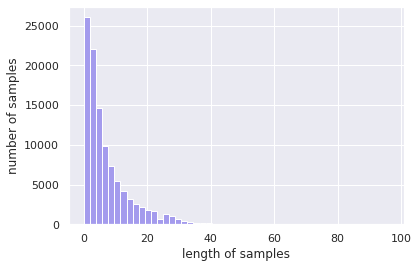

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50, color='#a49bed')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 90
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 90 이하인 샘플의 비율: 99.99717274526435


최대 길이가 96일 때, 90정도로 길이를 맞춰주면 리뷰의 99.99%가 온전히 보전된다.

아래처럼 패딩할 경우 pad_sequences의 default값에 따라,
길이가 90이 안되면 앞쪽에 0으로 패딩을 해주고, 90이 초과하면 시퀀스 앞쪽에서 자른다.

In [ ]:
# pad_sequences default 
# maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### **PART 3: 컴퓨터에게 텍스트를 학습시켜보자.**

---

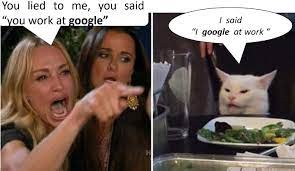

(이 이미지를 왜 넣었는지 감을 잡으셨다면, 박수를 쳐드립니다)


아래와 같이 모델 서로 다른 모델 5개를 훈련에 사용했다.
각각에 쓰인 하이퍼파라미터들은 일부 상이하며, 크게 조절하지 않았다.

1. SimpleRNN
2. LSTM
3. GRU
4. CNN (basic)
5. CNN (stacked)


왜 이런 모델들을 썼을까? 


- **RNN(Recurrent Neural Network, 순환 신경망)**
 
  순환구조를 이용해 과거의 학습을 현재에 반영하는 구조로, 순차적인(Sequential) 데이터 학습에 특화된 인공신경망의 한 종류. 

<img src="https://camo.githubusercontent.com/600319bf8af9600f19f8cd3904cb5a3f7b97b808/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f622f62352f526563757272656e745f6e657572616c5f6e6574776f726b5f756e666f6c642e737667" width="600">




- **LSTM(Long Term Short Memory, 장단기 기억망)**

  RNN 모델의 역전파 과정에서 activation function인 tanh의 미분값이 가지는 특징 때문에, Vanishing Gradient(기울기 소실) 이슈를 일으키는데 이를 해결하기 위해 역전파 값의 크기를 조절해주는 Gate를 추가함으로 이슈를 상쇄하는 모델. 

<img src="https://camo.githubusercontent.com/b3945f6f45d3c267dd668903cccd5768c2495d59/68747470733a2f2f696d67312e6461756d63646e2e6e65742f7468756d622f523132383078302f3f73636f64653d6d746973746f72793226666e616d653d687474702533412532462532466366696c65352e75662e746973746f72792e636f6d253246696d61676525324639393035434633383542443546354543303237463230" width="550">



- **GRU(Gated Recurrent Unit, 게이트 순환 유닛)**

  LSTM을 간소화시킨 버전의 모델. Gate를 2개만 사용한다. 
학습 속도가 LSTM보다 빠르지만 성능은 LSTM과 유사하다고 알려져 있음.

<img src="https://camo.githubusercontent.com/f4e855c9900b49d8fed270cc0b370eb867c19534/68747470733a2f2f696d67312e6461756d63646e2e6e65742f7468756d622f523132383078302f3f73636f64653d6d746973746f72793226666e616d653d687474702533412532462532466366696c65372e75662e746973746f72792e636f6d253246696d61676525324639394630454333453542443546363436303235354346" width="400">




- **CNN(Convolutional Neural Network, 합성곱 신경망)**

  기존의 학습들이 데이터에서 지식을 추출해내 이루어졌다면, CNN은 데이터에서 중요한 특징만을 뽑아내 특징들의 패턴을 찾아내는 방식으로 학습한다. 시각적 이미지 분석에 자주 사용되지만, 자연어처리에도 사용할 수 있다.

<img src="https://camo.githubusercontent.com/5bdd7aa6aaa15aaee8ac811253e26fd467bf94a0/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f313030302f312a4c5546556c5f3866715339376e557a7063466a6757772e706e67" width="600">



#### 3-1. simple RNN

In [ ]:
model_rnn = tf.keras.models.Sequential([
  tf.keras.layers.Embedding( vocab_size, 128, mask_zero=True), # mask_zero => 0으로 패딩된 부분을 연산에서 제외하고 학습 
  tf.keras.layers.SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_rnn.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model_rnn.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

history_rnn = model_rnn.fit(X_train, y_train, epochs=10, callbacks=[es], batch_size=32, validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         1797760   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 1,830,785
Trainable params: 1,830,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2653/2653 [==============================] - 500s 188ms/step - loss: 0.4576 - accuracy: 0.8197 - val_loss: 0.4279 - val_accuracy: 0.8342
Epoch 2/10
2653/2653 [==============================] - 487s 184ms/step - loss: 0.4108 - accuracy: 0.8378 - val_loss: 0.4193 - val_accuracy: 0.8336
Epoch 3/10
2653/2653 [==============================] - 487s 183ms/step - loss

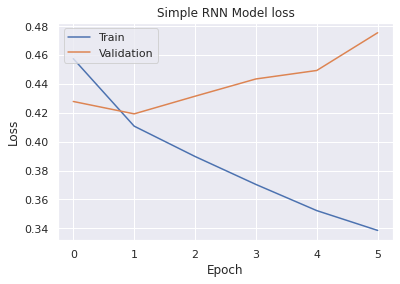

1106/1106 [==============================] - 15s 13ms/step - loss: 0.4772 - accuracy: 0.8162

 테스트 정확도: 0.8162


In [ ]:
# Plot training & validation loss values
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Simple RNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show();

print("\n 테스트 정확도: %.4f" % (model_rnn.evaluate(X_test, y_test)[1]))

y_pred_rnn = model_rnn.predict(X_test)

#### 3-2. LSTM

In [ ]:
model_lstm = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, 128, mask_zero=True),
  tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_rnn.summary()


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train, y_train, epochs=10, callbacks=[es], batch_size=32, validation_split=0.2)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         1797760   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 1,830,785
Trainable params: 1,830,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2653/2653 [==============================] - 1201s 451ms/step - loss: 0.4434 - accuracy: 0.8288 - val_loss: 0.4189 - val_accuracy: 0.8340
Epoch 2/10
2653/2653 [==============================] - 1194s 450ms/step - loss: 0.3924 - accuracy: 0.8475 - val_loss: 0.4145 - val_accuracy: 0.8366
Epoch 3/10
2653/2653 [==============================] - 1223s 461ms/step - l

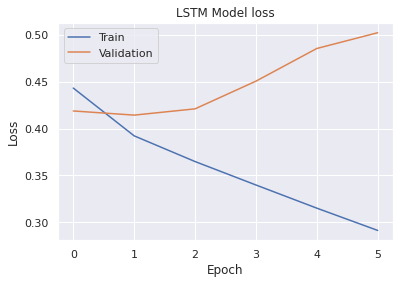

1106/1106 [==============================] - 37s 34ms/step - loss: 0.5084 - accuracy: 0.8217

 테스트 정확도: 0.8217


In [ ]:
# Plot training & validation loss values
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show();

print("\n 테스트 정확도: %.4f" % (model_lstm.evaluate(X_test, y_test)[1]))

y_pred_lstm = model_lstm.predict(X_test)

#### 3-3. GRU


In [ ]:
model_gru = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, 128, mask_zero=True),
  tf.keras.layers.GRU(128, dropout=0.2, recurrent_dropout=0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model_gru.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

model_gru.summary()

history_gru = model_gru.fit(X_train, y_train, epochs=10, callbacks=[es], batch_size=32, validation_split=0.2)

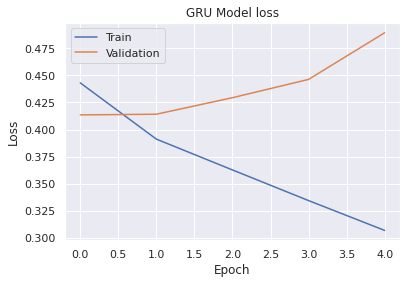

1106/1106 [==============================] - 34s 31ms/step - loss: 0.4959 - accuracy: 0.8190

 테스트 정확도: 0.8190


In [ ]:
# Plot training & validation loss values
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('GRU Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show();

print("\n 테스트 정확도: %.4f" % (model_gru.evaluate(X_test, y_test)[1]))

In [ ]:
y_pred_gru = model_gru.predict(X_test)

#### 3-4. CNN (basic)

In [ ]:
model_cnn = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, 64, input_length=max_len, mask_zero=True),
  tf.keras.layers.Conv1D(64, 5, activation = 'relu', padding = 'same', kernel_regularizer=l2(0.01), kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02)),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02))
])

model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 90, 64)            898880    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 90, 64)            20544     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 919,489
Trainable params: 919,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_cnn.compile(optimizer=RMSprop(lr = .0005), loss='binary_crossentropy', metrics=['accuracy'])
reLR = ReduceLROnPlateau(patience = 5, verbose=1, factor = .2)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience = 2)

In [ ]:
%%time
history_cnn = model_cnn.fit(X_train,
                            y_train,
                            epochs=10,
                            batch_size=32,
                            shuffle=True,
                            validation_split=0.2,
                            verbose = 1,
                            callbacks=[es, reLR])

Epoch 1/10
2653/2653 [==============================] - 18s 6ms/step - loss: 0.5141 - accuracy: 0.7921 - val_loss: 0.4788 - val_accuracy: 0.7989
Epoch 2/10
2653/2653 [==============================] - 17s 6ms/step - loss: 0.4860 - accuracy: 0.7921 - val_loss: 0.4740 - val_accuracy: 0.7989
Epoch 3/10
2653/2653 [==============================] - 17s 6ms/step - loss: 0.4821 - accuracy: 0.7924 - val_loss: 0.4706 - val_accuracy: 0.8002
Epoch 4/10
2653/2653 [==============================] - 17s 6ms/step - loss: 0.4794 - accuracy: 0.7938 - val_loss: 0.4702 - val_accuracy: 0.8005
Epoch 5/10
2653/2653 [==============================] - 16s 6ms/step - loss: 0.4771 - accuracy: 0.7945 - val_loss: 0.4740 - val_accuracy: 0.7989
Epoch 6/10
2653/2653 [==============================] - 17s 6ms/step - loss: 0.4758 - accuracy: 0.7952 - val_loss: 0.4700 - val_accuracy: 0.7989
Epoch 7/10
2653/2653 [==============================] - 16s 6ms/step - loss: 0.4740 - accuracy: 0.7960 - val_loss: 0.4688 - val_ac

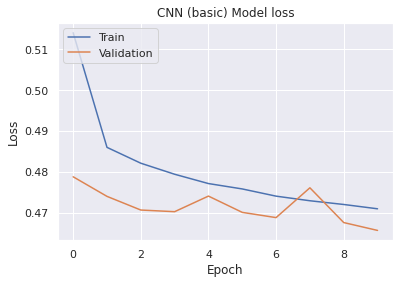

1106/1106 [==============================] - 3s 2ms/step - loss: 0.4756 - accuracy: 0.7969

 테스트 정확도: 0.7969


In [ ]:
# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('CNN (basic) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show();

print("\n 테스트 정확도: %.4f" % (model_cnn.evaluate(X_test, y_test)[1]))

y_pred_cnn = model_cnn.predict(X_test)

#### 3-5. CNN(stacked)

In [ ]:
model_cnn2 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, 64, input_length = max_len),
  tf.keras.layers.Conv1D(64, 5, activation = 'relu',kernel_regularizer= l2(0.001)),
  tf.keras.layers.MaxPooling1D(5),
  tf.keras.layers.Dropout(.5),
  tf.keras.layers.Conv1D(64, 5, activation = 'relu',kernel_regularizer= l2(0.001)),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02))
])

model_cnn2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 90, 64)            898880    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 86, 64)            20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 13, 64)            20544     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)               

In [ ]:
%%time
model_cnn2.compile(optimizer = RMSprop(lr = .0005), loss = 'binary_crossentropy', metrics = ['acc'])

es = [EarlyStopping(monitor = 'val_loss', patience = 2, mode = 'min', verbose = 1)]

history_cnn2 = model_cnn2.fit(X_train,
                              y_train,
                              epochs = 10,
                              batch_size = 32,
                              verbose = 1,
                              validation_split = 0.2,
                              callbacks=es)

Epoch 1/10
2653/2653 [==============================] - 22s 8ms/step - loss: 0.5078 - acc: 0.7974 - val_loss: 0.4549 - val_acc: 0.8222
Epoch 2/10
2653/2653 [==============================] - 21s 8ms/step - loss: 0.4593 - acc: 0.8175 - val_loss: 0.4449 - val_acc: 0.8235
Epoch 3/10
2653/2653 [==============================] - 22s 8ms/step - loss: 0.4495 - acc: 0.8231 - val_loss: 0.4377 - val_acc: 0.8265
Epoch 4/10
2653/2653 [==============================] - 21s 8ms/step - loss: 0.4446 - acc: 0.8245 - val_loss: 0.4366 - val_acc: 0.8267
Epoch 5/10
2653/2653 [==============================] - 21s 8ms/step - loss: 0.4417 - acc: 0.8263 - val_loss: 0.4392 - val_acc: 0.8260
Epoch 6/10
2653/2653 [==============================] - 21s 8ms/step - loss: 0.4387 - acc: 0.8286 - val_loss: 0.4362 - val_acc: 0.8298
Epoch 7/10
2653/2653 [==============================] - 21s 8ms/step - loss: 0.4365 - acc: 0.8284 - val_loss: 0.4336 - val_acc: 0.8285
Epoch 8/10
2653/2653 [==============================] -

In [ ]:
# Plot training & validation loss values
plt.plot(history_cnn2.history['loss'])
plt.plot(history_cnn2.history['val_loss'])
plt.title('CNN (stacked) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show();

print("\n 테스트 정확도: %.4f" % (model_cnn2.evaluate(X_test, y_test)[1]))
y_pred_cnn2 = model_cnn2.predict(X_test)

### **PART 4: 예측 결과를 뜯어보고, 적절한 모델을 선택하자.**

In [ ]:
pred_result = pd.concat([
                     pd.DataFrame(y_pred_rnn),
                     pd.DataFrame(y_pred_lstm),
                     pd.DataFrame(y_pred_gru),
                     pd.DataFrame(y_pred_cnn),
                     pd.DataFrame(y_pred_cnn2)
                     ], axis=1)

model_lst = ['SimpleRNN', 'LSTM', 'GRU', 'CNN', 'CNN(stacked)']
pred_result.columns = model_lst

# 리뷰데이터의 테스트셋에, 모델별 예측점수를 합쳐준다.
idx_lst = y_test.index.tolist()
info_lst = ['userId', 'reviewScore', 'reviewDetail', 'label']
info_df = df.loc[idx_lst][info_lst].reset_index(drop=True)
result_df = pd.concat([info_df, pred_result], axis=1)


# 점수 대신 문자열로 보기 위한 작업
# 0.5 초과는 긍정, 미만은 부정, 0.5와 같으면 중립으로 문자열 변경
conds = [pred_result.values < 0.5 , pred_result.values > 0.5]
choices = ['Negative', 'Positive']

convert_str_df = pd.DataFrame(np.select(conds, choices, default='Neutral'),
                           index=pred_result.index,
                           columns=pred_result.columns
)

result_str_df = pd.concat([ info_df, convert_str_df ], axis=1)
result_str_df['label'] = result_str_df['label'].apply(lambda x: 'Positive' if x==1 else 'Negative')

In [ ]:
# from google.colab import files

# result_df.to_csv('final_result_df.csv')
# result_str_df.to_csv('final_result_str_df.csv')
# files.download('final_result_df.csv')
# files.download('final_result_str_df.csv')

## colab 런타임 끊겼을 때 사용
# result_df = pd.read_csv(project_dir + '/result_df (1).csv', index_col=[0])
# result_str_df = pd.read_csv(project_dir + '/result_str_df (1).csv', index_col=[0])
# model_lst = ['SimpleRNN', 'LSTM', 'GRU', 'CNN', 'CNN(stacked)']

#### 4-1. 결과 한 눈에 살펴보기

In [ ]:
bar_source = result_str_df[result_str_df.columns.tolist()[3:]]

count_base = []
for col in bar_source.columns:
  count_base.append(bar_source[col].value_counts().tolist())

bar_data = pd.DataFrame(count_base, columns=['Positive', 'Negative'], index=['y_test'] + model_lst)

bar_data['Positive'] = round(bar_data['Positive']/len(y_test)*100, 1)
bar_data['Negative'] = round(bar_data['Negative']/len(y_test)*100, 1)

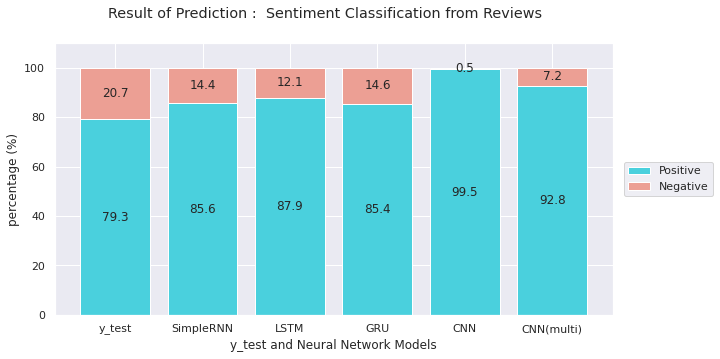

In [ ]:
# draw figure
plt.figure(figsize=(10,5))

# set data
x = bar_data.index
y1 = bar_data['Positive']
y2 = bar_data['Negative']

# add colors
colors = ['#4ad0dd', '#ec9f94']

# stack bars
plt.bar(x, y1, label='Positive', color=colors[0])
plt.bar(x, y2, bottom=y1, label='Negative', color=colors[1])

# add text annotation corresponding to the percentage of each data.
for xpos, ypos, yval in zip(x, y1/2, y1):
    plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
for xpos, ypos, yval in zip(x, y1+y2/2, y2):
    plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")

# set detail
plt.ylim(0,110)
plt.suptitle('Result of Prediction :  Sentiment Classification from Reviews')
plt.xlabel('y_test and Neural Network Models')
plt.ylabel('percentage (%)')

plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left');

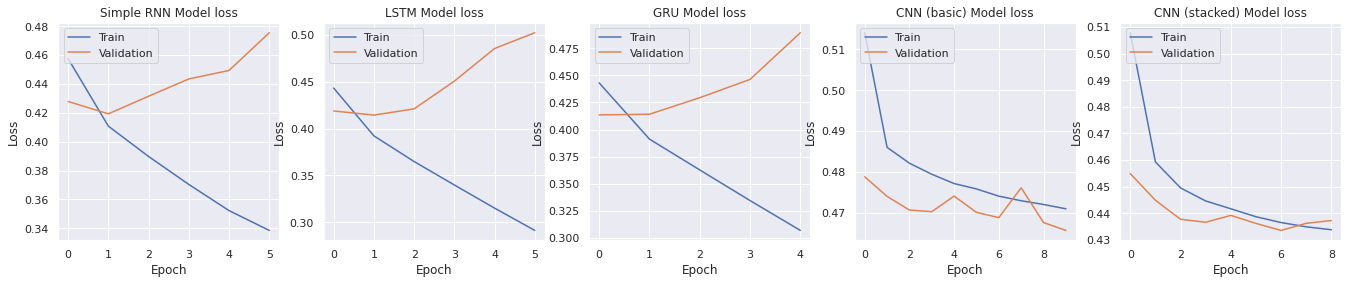

1106/1106 [==============================] - 16s 15ms/step - loss: 0.4772 - accuracy: 0.8162

 simple rnn 테스트 정확도: 0.8162
1106/1106 [==============================] - 40s 36ms/step - loss: 0.5084 - accuracy: 0.8217

 LSTM 테스트 정확도: 0.8217
1106/1106 [==============================] - 36s 33ms/step - loss: 0.4959 - accuracy: 0.8190

 GRU 테스트 정확도: 0.8190
1106/1106 [==============================] - 3s 3ms/step - loss: 0.4756 - accuracy: 0.7969

 CNN(basic) 테스트 정확도: 0.7969
1106/1106 [==============================] - 3s 3ms/step - loss: 0.4458 - acc: 0.8259

 CNN(stacked) 테스트 정확도: 0.8259


In [ ]:
# draw figure, location, and size
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(23,4))

# set figure by location
ax1.plot(history_rnn.history['loss'])
ax1.plot(history_rnn.history['val_loss'])
ax1.set_title('Simple RNN Model loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history_lstm.history['loss'])
ax2.plot(history_lstm.history['val_loss'])
ax2.set_title('LSTM Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

ax3.plot(history_gru.history['loss'])
ax3.plot(history_gru.history['val_loss'])
ax3.set_title('GRU Model loss')
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.legend(['Train', 'Validation'], loc='upper left')

ax4.plot(history_cnn.history['loss'])
ax4.plot(history_cnn.history['val_loss'])
ax4.set_title('CNN (basic) Model loss')
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epoch')
ax4.legend(['Train', 'Validation'], loc='upper left')

ax5.plot(history_cnn2.history['loss'])
ax5.plot(history_cnn2.history['val_loss'])
ax5.set_title('CNN (stacked) Model loss')
ax5.set_ylabel('Loss')
ax5.set_xlabel('Epoch')
ax5.legend(['Train', 'Validation'], loc='upper left')

plt.show()

print("\n simple rnn 테스트 정확도: %.4f" % (model_rnn.evaluate(X_test, y_test)[1]))
print("\n LSTM 테스트 정확도: %.4f" % (model_lstm.evaluate(X_test, y_test)[1]))
print("\n GRU 테스트 정확도: %.4f" % (model_gru.evaluate(X_test, y_test)[1]))
print("\n CNN(basic) 테스트 정확도: %.4f" % (model_cnn.evaluate(X_test, y_test)[1]))
print("\n CNN(stacked) 테스트 정확도: %.4f" % (model_cnn2.evaluate(X_test, y_test)[1]))

#### 4-2. 어떻게 예측했을까?
(⚠️ 주의: 변수명은 Confusion Matrix를 참고하여 임의로 지정했을 뿐, *실제로 존재하는 단어는 아님*)

CASE 1) 모든 모델이 예측이 모두 빗나갔을 때

- XFN(exclusive False Negative) : 모든 모델의 예측이 틀렸고, 모두 예측을 Negative로 함.(=라벨 값이 Positive)
- XFP(exclusive False Positive) : 모든 모델의 예측이 틀렸고, 모두 예측을 Positive로 함.(=라벨 값이 Negative)

CASE 2) 특정 모델 1개만 맞는 예측을 하고, 다른 모델은 모두 틀린 예측을 했을 때

- OFN(the Others are False Negative) : 라벨이 P인데, 모델 하나만 Positive를 맞췄고, 나머지 모델은 다 틀렸을때(=Negative로 예측)
- OFP(the Others are False Positive) : 라벨이 N인데, 모델 하나만 Negative를 맞췄고 나머지 모델은 다 틀렸을때(=Positive로 예측 )

CASE 3) 모든 모델이 다 예측을 정확히 했을 때

- XTP(exclusive True Positive) : 라벨이 P이고, 모든 모델이 P라고 예측함
- XTN(exclusive True Negative) : 라벨이 N이고, 모든 모델이 N라고 예측함

In [ ]:
# 계산이 쉽도록, Positive를 True(1), Negative를 False(0)으로 바꿔줌.
# 모델별로 예측한 값을 가로로 더해 관측치 x에 대한 예측 값들이 어떤지 패턴을 확인하기 위함.
convert_boolean = result_str_df[['label'] + model_lst].replace({'Positive':True, 'Negative':False})
convert_boolean['sum'] = convert_boolean[model_lst].sum(axis=1)

# Label이 True일 때 : 모두 틀리면 예측했으면 0, 하나만 맞았으면 1, 모두 맞으면 5 
XFN = convert_boolean[(convert_boolean['label']==True)&(convert_boolean['sum']==0)].index.tolist()
OFN = convert_boolean[(convert_boolean['label']==True)&(convert_boolean['sum']==1)].index.tolist()
XTP = convert_boolean[(convert_boolean['label']==True)&(convert_boolean['sum']==5)].index.tolist()

# Label이 False일 때 : 모두 틀리게 예측했으면 5, 하나만 맞게 예측했으면 4, 모두 맞았으면 0 
XFP = convert_boolean[(convert_boolean['label']==False)&(convert_boolean['sum']==5)].index.tolist()
OFP = convert_boolean[(convert_boolean['label']==False)&(convert_boolean['sum']==4)].index.tolist()
XTN = convert_boolean[(convert_boolean['label']==False)&(convert_boolean['sum']==0)].index.tolist()

COL = ['reviewDetail', 'reviewScore', 'label'] + model_lst

In [ ]:
# customize color with style
def coloring_positive(val):
    color = 'white' if val == 'Positive' else 'black'
    bgcolor = '#4ad0dd' if val == 'Positive' else 'white'
    return 'background-color: %s ; color: %s'% (bgcolor,color)

def coloring_negative(val):
    color = 'white' if val == 'Negative' else 'black'
    bgcolor = '#ec9f94' if val == 'Negative' else 'white'
    return 'background-color: %s ; color: %s'% (bgcolor,color)    

아래 케이스들은, 라벨이 긍정/부정을 판단하기 어려운 경우다. 별점이 높아도 만족도는 떨어질 수 있고, 별점이 낮아도 만족도는 높을 수 있다.



In [ ]:
# 예측이 모두 틀렸으나, 사실상 틀린 예측이 맞는 감성일 때 
(result_str_df.loc[XFN][COL][:20].style
                                 .applymap(coloring_positive)
                                 .format({'reviewScore': '{:.1f}'})
)

,reviewDetail,reviewScore,label,SimpleRNN,LSTM,GRU,CNN,CNN(multi)
1164,맛없어짐,5.0,Positive,Negative,Negative,Negative,Negative,Negative
8443,별로맛없어요 후기보고 기대했는데 비린내나고 별 맛이안나네여,4.5,Positive,Negative,Negative,Negative,Negative,Negative
10491,이렇게맛없기도 힘든붕어빵인데,5.0,Positive,Negative,Negative,Negative,Negative,Negative
14152,그냥 그래요 봉골레는 별로에요 카프레제는 양도많고 질도 좋네요,4.0,Positive,Negative,Negative,Negative,Negative,Negative
19936,고기 완전 맛없었어요실망ㅠㅜ,5.0,Positive,Negative,Negative,Negative,Negative,Negative
22015,빙수는별로 ㅜ,3.5,Positive,Negative,Negative,Negative,Negative,Negative
30651,맛없어요 미원 한수저 먹은것 같아요고기는 오래된 냉동실 고기냄새 밥도 진짜 휴 최악입니다,5.0,Positive,Negative,Negative,Negative,Negative,Negative
31541,그냥그냥 그래여,3.5,Positive,Negative,Negative,Negative,Negative,Negative


In [ ]:
# 모델 1개만 예측을 맞추고 다른 모델은 틀린 예측을 했을 때.
# 이 또한 틀린 예측이 올바른 감성인 경우가 주를 이룸.

(result_str_df.loc[OFN][COL][:20].style
                                 .applymap(coloring_positive)
                                 .format({'reviewScore': '{:.1f}'})
)

,reviewDetail,reviewScore,label,SimpleRNN,LSTM,GRU,CNN,CNN(multi)
273,그럭저럭 괜찮아요,3.5,Positive,Negative,Negative,Negative,Positive,Negative
334,김밥은 별로 에요 튀김이랑 떡뽁이는 맛있었어요,4.0,Positive,Negative,Negative,Negative,Positive,Negative
507,맛은 있는데 재첩국양이이걸 만천원에 파는건 좀 ㅠㅠ 재첩 알갱이두 너무 작구 좀 아쉽네요 ㅠ,5.0,Positive,Negative,Negative,Negative,Positive,Negative
544,슈크림빵 두개 주문했고 영수증에도 두개로 계산됐는데 왜 하나만 옴 장난함 빵 받아놓고 늦게 확인했더니기사님이 실수한건지 파바에서 그런건지 개짜증나는데 일 좀 똑바로하세요ㅡㅡ,4.0,Positive,Negative,Negative,Negative,Positive,Negative
551,비빔밥은 솔직히 맛없음 ㅠㅠ 나머진 다 맛있음,5.0,Positive,Negative,Negative,Negative,Positive,Negative
553,그냥뭐,5.0,Positive,Negative,Negative,Negative,Negative,Positive
668,깨진컵에 반이나 사라지고 뒤죽박죽 참 이걸 먹으라고 보내주신건지 한숨만나옵니다,3.5,Positive,Negative,Negative,Negative,Positive,Negative
696,회덮밥을 방어로하신건별루인것같아요ㅜ제철생선이라도 방어는금방비려져서요,3.5,Positive,Negative,Negative,Negative,Positive,Negative
722,국물 시원하구 좋았어요3개시켰는데하나는 다 터져서 봉투가 한강그냥 버렸네요포장 신경좀 쓰세요,5.0,Positive,Negative,Negative,Negative,Positive,Negative
756,비프 크림파스타인데 비프 어디있어요 버섯은요 재료 너무 아끼셨네비프맛은 또 왜이러냐ㅡㅡ 이집다신안먹어,5.0,Positive,Negative,Negative,Negative,Positive,Negative


In [ ]:
# 예측이 모두 틀렸으나, 사실상 틀린 예측이 맞는 감성이 주를 이룸.
(result_str_df.loc[XFP][COL][:20].style
                                 .applymap(coloring_negative)
                                 .format({'reviewScore': '{:.1f}'})
)

,reviewDetail,reviewScore,label,SimpleRNN,LSTM,GRU,CNN,CNN(multi)
7,매운맛드세요 오돌뼈 안매운맛 좀느끼해용,1.5,Negative,Positive,Positive,Positive,Positive,Positive
8,맛있어요 게장 ㅎ,1.5,Negative,Positive,Positive,Positive,Positive,Positive
9,배달빠르고 맛나요,1.0,Negative,Positive,Positive,Positive,Positive,Positive
33,잘먹었습니다또 시킬께요,1.0,Negative,Positive,Positive,Positive,Positive,Positive
41,뿌링치즈볼로 변경요청했는데 보통으로 왔네요 500원차이라 귀찮아서 뒀는데 조심하셔야할듯 합니다,2.0,Negative,Positive,Positive,Positive,Positive,Positive
42,맛있어요,1.0,Negative,Positive,Positive,Positive,Positive,Positive
49,굿,1.0,Negative,Positive,Positive,Positive,Positive,Positive
83,빠르고 맛있게 잘먹었습니다,1.0,Negative,Positive,Positive,Positive,Positive,Positive
86,떡복이는 맛이좋았구여 다만 순대가 기대치보다 낮았어여,2.5,Negative,Positive,Positive,Positive,Positive,Positive
88,맛있어요 가볍고 든든하니 좋아요,1.0,Negative,Positive,Positive,Positive,Positive,Positive


아래 케이스는 모델 1개만 예측을 올바르게 했고, 나머지 모델은 다 틀리게 예측한 케이스이다.

전체적으로 라벨과 리뷰의 감성이 일치하기때문에, 여기서 부정적인 리뷰를 얼마나 잘 맞췄는지가 모델을 결정할 때 중요한 포인트가 될 것 같다.

In [ ]:
(result_str_df.loc[OFP][COL][:20].style
                                 .applymap(coloring_negative)
                                 .format({'reviewScore': '{:.1f}'})
)

,reviewDetail,reviewScore,label,SimpleRNN,LSTM,GRU,CNN,CNN(multi)
10,요청사항은 항상 무시해버립니다계란찜 너무짜서 계란2개 넣고 다시 조리해먹었어요,0.5,Negative,Positive,Positive,Negative,Positive,Positive
50,집에서 걍 김치볶음밥해드셔요,1.0,Negative,Positive,Positive,Negative,Positive,Positive
66,튀김 속이 더잘익어야할듯,1.5,Negative,Negative,Positive,Positive,Positive,Positive
115,샐러드는 맛있는데 다만 곁들여주시는 아보카도가 약간 상하기 직전이였고 특히나 과카몰리는 색이 완전히 변해있었어요ㅠㅠ 다음부터는 원래대로의 신선한 연두색 과카몰리로 부탁드립니다,1.0,Negative,Positive,Positive,Negative,Positive,Positive
141,식해제육의 식해 간이 살짝 짜더라고요 그것 빼고는 만족스러운 맛이었답니다,2.0,Negative,Positive,Positive,Negative,Positive,Positive
178,우유 빙수가아니었어요,1.0,Negative,Negative,Positive,Positive,Positive,Positive
222,너무뜨거운상태그대로 넣으셨는지 낙지볶음 용기가옆에녹아서 다세고 ㅜ바닥이랑닦느라진짜짜증생각보다하나도안맵고 맛이오묘했음 ㅜ수제비는 후기보단 살짝 간이좀 쎘었고많이 졸여진상태흠,2.0,Negative,Positive,Positive,Negative,Positive,Positive
262,배달전에 뭐 빼고 달라고 썼는데 반영이 안되네여,2.5,Negative,Positive,Positive,Negative,Positive,Positive
265,된장찌게는 안가지고왔네요잘좀챙겨오세요,1.0,Negative,Negative,Positive,Positive,Positive,Positive
272,빠른배송감사합니다 빠른배송감사합니다 빠른배송감사합니다 빠른배송 빠른배송감사합니다 빠른배송감사합니다 빠른배송 빠른배송감사합니다 빠른배송감사합니다 빠른배송감사합니다 빠른배송감사합니다,1.0,Negative,Negative,Positive,Positive,Positive,Positive


#### 4-3. 그래서 어떤 모델을 선택해야 할까?

- 부정적인 리뷰를 긍정이라고 예측하는 케이스 (1종 오류)
- 긍정적인 리뷰를 부정이라고 예측하는 케이스 (2종 오류)

둘 중에 어떤 오류를 줄이는 데 힘을 써야 할까? 유저들은 좋았던 경험보다, **안좋았던 경험에 더 민감**하다.

내 취향에 맞는 영역을 추천 해 주는 서비스에서, 내 취향이 아닌 리스트가 먼저 노출된다면 사용자 경험을 좋게 끌어올리기 어렵다. 따라서 우리는 '부정적인 리뷰를 최대한 잘 걸러내는 것'에 초점을 맞춰야 한다.

    1. 부정적인 리뷰를 잘 걸러내야 한다. ==> True Negative가 비교적 커야한다.
    2. 긍정적이라고 예측해서 노출했는데, 알고보니 부정적인 리뷰인 케이스를 줄여야 한다. ==> False Positive가 비교적 작아야 한다.

  1,2를 모두 만족하는 GRU 모델을 선택하는 것이 적절하다. 

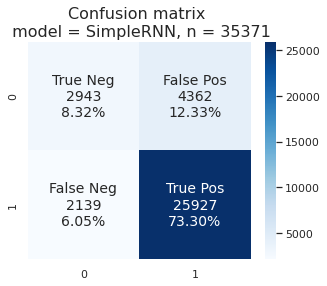

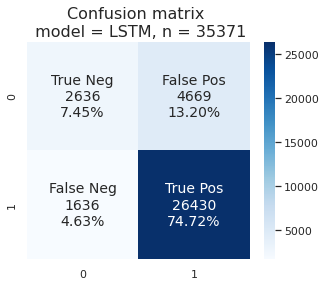

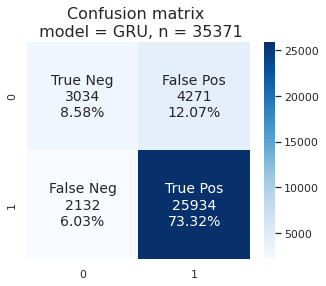

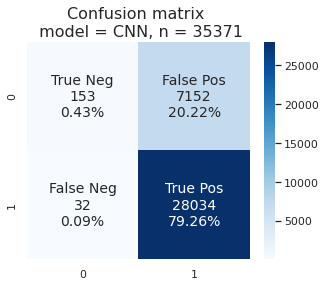

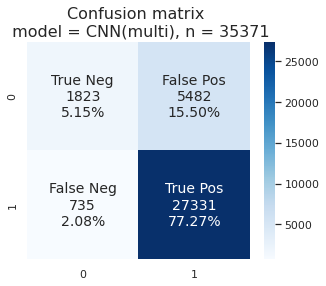

In [ ]:
for col in model_lst:
  fig, ax = plt.subplots(figsize=(5,4))
  # Set general font size
  plt.rcParams['font.size'] = '14'

  cf_matrix = confusion_matrix(y_test, convert_boolean[col])

  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  plt.title(f'Confusion matrix \n model = {col}, n = {len(y_test)}', fontsize=16)
  plt.show()

In [ ]:
# GRU 모델로 예측한 리뷰의 긍정&부정 정도. 1에 가까울수록 긍정, 0에 가까울수록 부정.
# 리뷰점수가 높아도, 비교적 리뷰의 감성을 잘 판단해내고 있음을 확인할 수 있다.
(result_df[result_df.userId=='f1bfa36c116148572b5add1ad7cd7c3ce8d8aac3'][['reviewDetail', 'reviewScore', 'GRU']]
 .sort_values(['GRU','reviewScore'], ascending=[False,True])
)

,reviewDetail,reviewScore,GRU
1136,다맛잇어요 ㅋㅋ핫도그도맛잇엇구잘먹엇어영,5.0,0.999246
10083,히히,5.0,0.998868
18840,히히,5.0,0.998868
19845,감사해용,5.0,0.998868
7901,맛고을 짱,5.0,0.997348
...,...,...,...
27128,오늘은 피자가별로 ㅜ,4.5,0.294036
23754,족발이좀냄새가낫어요ㅜ보쌈이훨맛잇는것같아요여긴,4.5,0.215473
4255,그냥그래요,1.0,0.197249
7528,다식어서오고 그냥그럼,4.0,0.162149


#### 4-4. 학습한 모델에 새로운 문구를 넣어 예측해보자.

In [ ]:
def sentiment_predict(model, new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_morphs_lst] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict(model_rnn, '진짜 배송도 늦고 짜증나네요. 뭐 이런 걸 먹으라고 만듬?')
sentiment_predict(model_lstm, '진짜 배송도 늦고 짜증나네요. 뭐 이런 걸 먹으라고 만듬?')
sentiment_predict(model_gru, '진짜 배송도 늦고 짜증나네요. 뭐 이런 걸 먹으라고 만듬?')
sentiment_predict(model_cnn, '진짜 배송도 늦고 짜증나네요. 뭐 이런 걸 먹으라고 만듬?')
sentiment_predict(model_cnn2, '진짜 배송도 늦고 짜증나네요. 뭐 이런 걸 먹으라고 만듬?')

81.97% 확률로 부정 리뷰입니다.
56.62% 확률로 부정 리뷰입니다.
94.54% 확률로 부정 리뷰입니다.
81.27% 확률로 긍정 리뷰입니다.
73.00% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict(model_rnn, '사장님... 대박나세옄큐ㅠㅠㅠㅠㅠㅠ')
sentiment_predict(model_lstm, '사장님... 대박나세옄큐ㅠㅠㅠㅠㅠㅠ')
sentiment_predict(model_gru, '사장님... 대박나세옄큐ㅠㅠㅠㅠㅠㅠ')
sentiment_predict(model_cnn, '사장님... 대박나세옄큐ㅠㅠㅠㅠㅠㅠ')
sentiment_predict(model_cnn2, '사장님... 대박나세옄큐ㅠㅠㅠㅠㅠㅠ')

87.51% 확률로 긍정 리뷰입니다.
98.32% 확률로 긍정 리뷰입니다.
85.57% 확률로 긍정 리뷰입니다.
84.50% 확률로 긍정 리뷰입니다.
92.69% 확률로 긍정 리뷰입니다.


### **PART 5. 결론 정리 & 한계점**

---

**Review**
  - 성능은 stacked CNN 모델이 정확도 0.8242로 제일 좋았고, 훈련 데이터와 검증 데이터의 로스가 함께 줄어드는 패턴도 CNN 모델들에서 발견되었다. 따라서 점수만 보면, CNN 모델을 채택해 활용할 것 같다.

  - 그러나 분류된 결과를 확인해보니, 리뷰 점수와 리뷰의 감성이 반드시 일치하지 않는 케이스가 있었다.(리뷰 점수가 높다고 만족도가 높은게 아니며, 점수가 낮다고 마냥 만족도가 낮은 것도 아니다.)

  - 따라서 모델의 정확도만 가지고 좋은 모델이라 평가할 수 없다.

  - 유저는 안좋았던 경험에 더 민감하다. 따라서 음식점 추천 리스트에 유저의 취향을 반영한다고 했을 때, 유저가 만족했던 음식점을 정교하게 추천해주는 것도 좋지만, 불만족한 식당을 추천리스트에 내놓아선 안될 것이다.
  
  - 그러므로 부정적인 리뷰를 잘 필터해 낼 수 있도록 부정리뷰를 걸러내는 능력이 좋고 + 부정리뷰를 긍정으로 예측하는 비중이 적은 모델을 선택하는 것이 목적에 부합하다. 

  - 따라서 Confusion Matrix를 그렸을때 TN의 비중이 비교적 크고, FP의 비중이 비교적 작은 GRU 모델을 활용하여 유저들의 감성분석을 진행하는 것이 적절하다고 판단했다.

  - 이렇게 만든 모델을 활용하여, 리뷰 내용을 넣으면 유저의 감성을 예측해 해당 유저가 특정 상품, 특정 카테고리에 얼만큼 선호도가 있는지를 바탕으로 고객 세그먼트를 나누는데 활용할 수 있다. 

  - 이 외에도, 별점이 음식점의 케파를 결정하는 배달 앱에서 사용자의 만족도를 별점만으로 평가할 수 없을 때 보조지표로 활용할 수 있다. 

  - 리뷰를 쓴 시간정보가 더해지면, 리뷰를 쓴 시간대 날짜, 감성 점수를 활용해 유저의 퍼소나(personas)를 구분지을 수도 있다.


**한계점**

  - 반드시 딥러닝을 활용해서 풀어야 할 문제는 아니다. scikit-learn을 활용해 머신러닝으로도 비교적 가볍게 처리할 수 있는 분류문제이다.

  - GRU 모델은 RNN, LSTM에 비해서는 연산속도가 빠르지만, 여전히 CNN에 비해 현저히 느리다. 
  (학습시간 GRU 40분 -> CNN 3분) 
  이 부분은 tensorflow 2.0에서 내장 LSTM 및 GRU 레이어는 GPU를 사용할 수 있을 때 기본적으로 [CuDNN 커널을 활용하도록 업데이트](https://tensorflow.google.cn/guide/keras/rnn?hl=ko)되었지만, 이 프로젝트에서 구현한 모델은 해당사항이 없어, 보완이 필요하다.

  - 긍정과 부정은 구분해 낼 수 있었지만, 어떤 점에서 만족했고, 어떤 점이 불만인지 세부 항목은 구분하지 못한다. 이 부분이 보완된다면, 부정적인 키워드를 활용해 개선의 지표로 활용할 수 있을 것이다.



### **PART 6. (내가 다시 보려고 만든)참고 자료**
[Section 4 - Sprint 2 : NLP](https://github.com/codestates/ds-section4-sprint2) 로 기초를 잡고, 구글링하여 얻은 지식을 살을 붙였다.


---

- 전처리 과정에 도움을 받은 블로그들

    [[자연어처리] 한국어 토큰화 구현(KoNLPy) : 한국어 텍스트 전처리는 어떻게 할까?](https://han-py.tistory.com/283)

    [[NLP]자연어처리 - 한국어 전처리를 위한 기법들](https://ebbnflow.tistory.com/246)

- 모델링 과정에서 도움을 받은 블로그들

    [네이버 쇼핑 리뷰 감성 분류하기](https://wikidocs.net/94600)

    [[문자]청와대 청원 : 청원의 주제는 무엇일까?](https://dacon.io/codeshare/1803?dtype=recent)
    
    [쇼핑몰 리뷰 감정분석에서 알고리즘 선택](https://it-techstory.tistory.com/2)

    [쉽게 이해하는 Batch size와 Epochs : 큰게 좋은가, 작은게 좋은가?](https://laheepapa.tistory.com/71)

    [Learning rate & batch size best 조합 찾기 (feat.논문리뷰와 실험결과)](https://inhovation97.tistory.com/32)

- 불용어 사전 정리

  [한국어 불용어(형태소) 고빈도어 리스트 100개(bab2min)](https://bab2min.tistory.com/544)

  [한국어 불용어 리스트(rank.nl)](https://www.ranks.nl/stopwords/korean)

  [한국어 불용어 리스트(github.com/spikeekips)](https://gist.github.com/spikeekips/40eea22ef4a89f629abd87eed535ac6a)

- 모델 결정과정에 참고한 사이트. 

  [분류성능평가지표 - Precision, Recall, and Accuracy](https://sumniya.tistory.com/26)

- 지금은 쓰지 않았지만, 인사이트를 얻는데 도움이 되었거나 나중에 구현해보고픈 욕심이 나는 자료들

  [김택현, 조단비, 이현영, 원혜진, 강승식, "BERT 언어 모델을 이용한 감정 분석 시스템”, 2020](https://manuscriptlink-society-file.s3-ap-northeast-1.amazonaws.com/kips/conference/2020fall/presentation/KIPS_C2020B0249.pdf)

  [한국어 용언의 원형 복원 (Korean lemmatization)](https://lovit.github.io/nlp/2018/06/07/lemmatizer/)

  [KoELECTRA](https://github.com/monologg/KoELECTRA)

  [KoBERT](https://github.com/SKTBrain/KoBERT)

  [KcBERT](https://github.com/Beomi/KcBERT)(끝.)